In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "/content/drive/MyDrive/asl_dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='training',
                                             seed=42, label_mode='categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='validation',
                                             seed=42, label_mode='categorical')

Found 2515 files belonging to 36 classes.
Using 1761 files for training.
Found 2515 files belonging to 36 classes.
Using 754 files for validation.


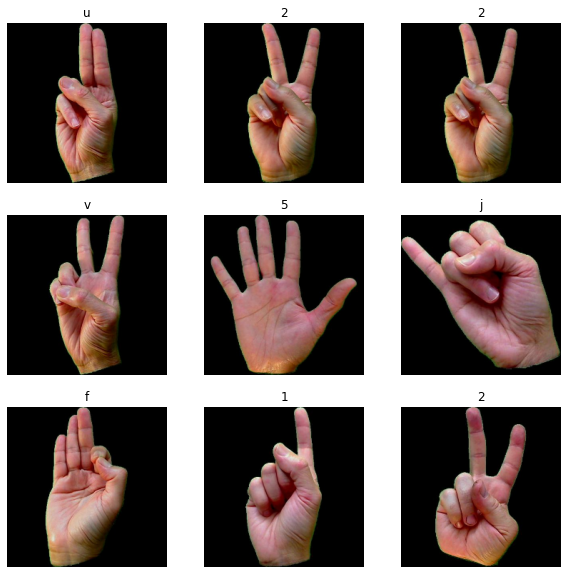

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  return data_augmentation

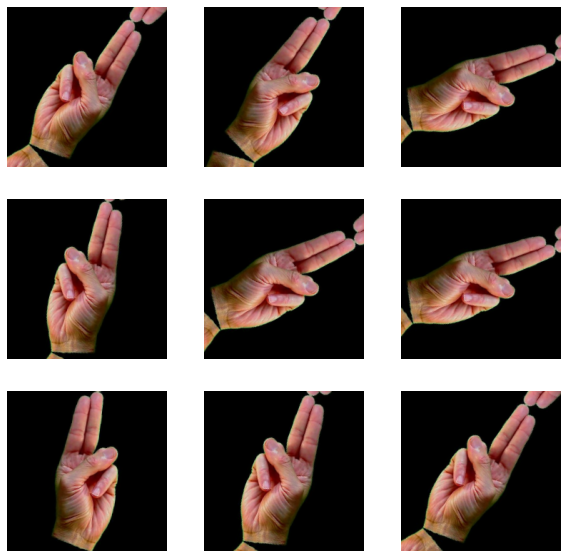

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [7]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet',classes= 1000, classifier_activation='softmax')

553476096/553467096 [==============================] - 13s 0us/step


In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
label_batch

(32, 1000)


<tf.Tensor: shape=(32, 36), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [11]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.vgg16.decode_predictions(pred.numpy(), top=2)

49152/35363 [=========================================] - 0s 0us/step


[[('n03929660', 'pick', 0.2106129), ('n02786058', 'Band_Aid', 0.18623571)],
 [('n03929660', 'pick', 0.3541197), ('n03666591', 'lighter', 0.104019284)],
 [('n02786058', 'Band_Aid', 0.37462577), ('n03929660', 'pick', 0.16183554)],
 [('n02786058', 'Band_Aid', 0.27363724),
  ('n03729826', 'matchstick', 0.0948635)],
 [('n02786058', 'Band_Aid', 0.41373286), ('n03929660', 'pick', 0.08521875)],
 [('n01955084', 'chiton', 0.7125783), ('n12768682', 'buckeye', 0.06484687)],
 [('n03929660', 'pick', 0.29307586), ('n02786058', 'Band_Aid', 0.24857041)],
 [('n02786058', 'Band_Aid', 0.30943337),
  ('n03729826', 'matchstick', 0.13852395)],
 [('n02786058', 'Band_Aid', 0.19075966), ('n03929660', 'pick', 0.12530574)],
 [('n03729826', 'matchstick', 0.20249812), ('n03929660', 'pick', 0.13531868)],
 [('n02786058', 'Band_Aid', 0.62825227), ('n03929660', 'pick', 0.13059787)],
 [('n03729826', 'matchstick', 0.2655334),
  ('n02786058', 'Band_Aid', 0.18097638)],
 [('n02786058', 'Band_Aid', 0.2904825),
  ('n03729826'

In [12]:
def asl_model(image_shape = IMG_SIZE, data_augmentation = data_augmenter()):
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                   include_top=False, #removes the top level layers; output layers
                                                   weights='imagenet', classes=26, classifier_activation='softmax') # From imageNet
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x) 
  x = base_model(x, training=False) 
  x = tfl.Flatten()(x)
  x = tfl.Dense(128)(x)
  x = tfl.Dense(128)(x)
  prediction_layer = tfl.Dense(36,activation="softmax")
  outputs = prediction_layer(x)

  model = tf.keras.Model(inputs, outputs)
  return model

In [13]:
model = asl_model(IMG_SIZE, data_augmentation)

58900480/58889256 [==============================] - 2s 0us/step


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                             

In [15]:
lr = 0.01
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [16]:
initial_epochs = 50
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
56/56 [==============================] - 804s 15s/step - loss: 26.7308 - accuracy: 0.3969 - val_loss: 12.9751 - val_accuracy: 0.6194
Epoch 2/50
56/56 [==============================] - 13s 226ms/step - loss: 8.9814 - accuracy: 0.7337 - val_loss: 5.9503 - val_accuracy: 0.7918
Epoch 3/50
56/56 [==============================] - 13s 227ms/step - loss: 6.4705 - accuracy: 0.7956 - val_loss: 3.4946 - val_accuracy: 0.8408
Epoch 4/50
56/56 [==============================] - 13s 229ms/step - loss: 4.2119 - accuracy: 0.8353 - val_loss: 3.9470 - val_accuracy: 0.8276
Epoch 5/50
56/56 [==============================] - 13s 231ms/step - loss: 3.4623 - accuracy: 0.8507 - val_loss: 3.8855 - val_accuracy: 0.8143
Epoch 6/50
56/56 [==============================] - 14s 240ms/step - loss: 3.2538 - accuracy: 0.8552 - val_loss: 2.8252 - val_accuracy: 0.8422
Epoch 7/50
56/56 [==============================] - 14s 233ms/step - loss: 2.4625 - accuracy: 0.8807 - val_loss: 2.3962 - val_accuracy: 0.851

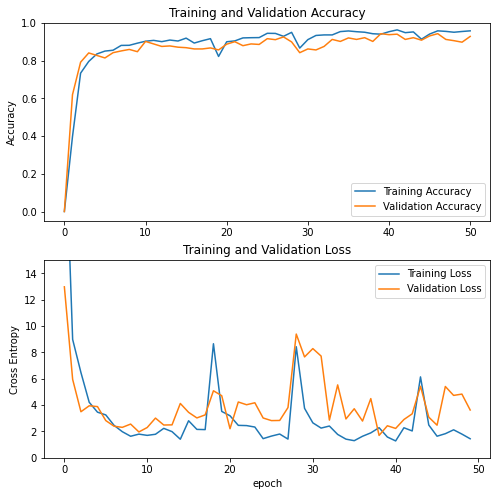

Highest Accuracy: 96.30891680717468%
Highest Validation Accuracy: 94.29708123207092%


In [17]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,15])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
print('Highest Accuracy: {}%'.format(max(history.history['accuracy'])*100))
print('Highest Validation Accuracy: {}%'.format(max(history.history['val_accuracy'])*100))

In [18]:
model.save('/content/drive/MyDrive/Trained Models/VGG16')